# References

- [Understanding EfficientNet](https://medium.com/mlearning-ai/understanding-efficientnet-the-most-powerful-cnn-architecture-eaeb40386fad)
- [Visualizing Feature Maps In Pytorch](https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Dependencies

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import Counter
from tqdm.notebook import tqdm
import time
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

# Importing Dataset

In [ ]:
# Define data transformations (resize, normalize, etc.)
resize_transform = v2.Compose([
    v2.Resize((224, 224)),  # Resize images to a common size
])
validation_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Define the dataset path (the directory containing "benign" and "malignant" subfolders)
dataset_path = '/content/drive/MyDrive/IT1244/images'
# dataset_path = 'images'

# Load the dataset using ImageFolder
dataset = ImageFolder(root=dataset_path, transform=resize_transform)
# Get the class-to-index mapping
class_to_idx = dataset.class_to_idx

# Get the class names
class_names = list(class_to_idx.keys())

# Use Counter to count the number of samples in each class
class_counts = dict(Counter(dataset.targets))

# Print the number of samples in each class
for class_name in class_names:
    count = class_counts[class_to_idx[class_name]]
    print(f"Class '{class_name}': {count} samples")

train_ratio = 0.8  # You can adjust this ratio as needed
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = train_test_split(dataset, test_size=test_size, train_size=train_size, random_state=42)
print("train_dataset: ", len(train_dataset))
print("test_dataset: ", len(test_dataset))

Class 'benign': 77 samples
Class 'malignant': 153 samples
train_dataset:  184
test_dataset:  46


# Image Augmentation

In [ ]:
class Augmentation:
  """
  Custom image augmentation class for applying multiple transformations to input images.

  Parameters:
  - num_augmentations (int): The number of augmentations to apply to each input image.
  - translation (tuple of floats): Maximum absolute fraction for horizontal and vertical translations.
  - shear (tuple of floats): Range of shearing angles (degrees).
  - rotation (tuple of floats): Range of clockwise rotation angles (degrees).

  Methods:
  - __call__(self, img_label): Apply augmentations to an input image-label pair.

  Usage:
  Instantiate the class and call it with an image-label pair to generate augmented images.

  Returns:
  - augmentations (list): A list of augmented image-label pairs. Each pair consists of an augmented image (torch.Tensor) and the original label.

  Example:
  augmentation = Augmentation()
  augmented_images = augmentation((input_image, input_label))
  """
  def __init__(self):
    self.num_augmentations = 10
    self.translation = (15 / 224, 15 / 224)
    self.shear = (-15, 15)
    self.rotation = (-25, 25)
    self.toTensor = v2.ToTensor()
    self.normalize = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

  def __call__(self, img_label):
    img, label = img_label
    augmentations = []
    for _ in range(self.num_augmentations):
      aug_transform = v2.RandomAffine(degrees=self.rotation, translate=self.translation, shear=self.shear)
      new_img = aug_transform(img)
      new_img = self.toTensor(new_img)
      new_img = self.normalize(new_img)
      augmentations.append((new_img, label))

    return augmentations

augmentation = Augmentation()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


# Modelling

In [ ]:
from torchvision.models import efficientnet_v2_m
class EfficientNet(nn.Module):
    def __init__(self, num_classes=2):
        super(EfficientNet, self).__init__()
        self.efficientnet = models.efficientnet_v2_m(weights='DEFAULT')

        ## Freeze model weights
        for param in self.efficientnet.parameters():
            param.requires_grad = False

        # Change the last layer of the model to fit our problem
        self.efficientnet.classifier = nn.Sequential(
            nn.Linear(1280, 2),
            # nn.Softmax(dim=1)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.efficientnet(x)
        return x

# Visualize Feature Maps

In [ ]:
model = EfficientNet()
transform = v2.Compose([
    v2.Resize((224, 224)),  # Resize images to a common size
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
def collect_conv2d_layers(module, weights, layers):
    for child in module.children():
        if isinstance(child, nn.Conv2d):
            weights.append(child.weight)
            layers.append(child)
        else:
            collect_conv2d_layers(child, weights, layers)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:02<00:00, 83.6MB/s]


Total convolutional layers: 245
First 10 feature maps:
torch.Size([24, 112, 112])
torch.Size([24, 112, 112])
torch.Size([24, 112, 112])
torch.Size([24, 112, 112])
torch.Size([96, 56, 56])
torch.Size([48, 56, 56])
torch.Size([192, 56, 56])
torch.Size([48, 56, 56])
torch.Size([192, 56, 56])
torch.Size([48, 56, 56])


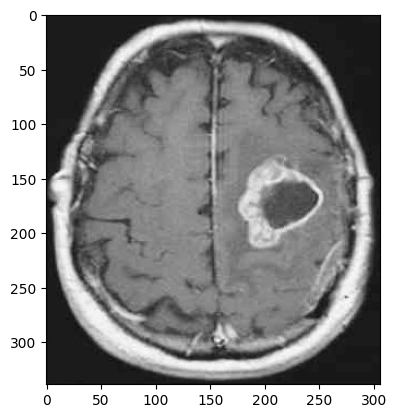

In [ ]:
### Visualising conv layers
model_weights = []
conv_layers = []
collect_conv2d_layers(model, model_weights, conv_layers)
print(f"Total convolutional layers: {len(conv_layers)}")
sample_image_path = os.path.join(dataset_path, 'malignant/10.jpg')
image = Image.open(sample_image_path)
plt.imshow(image)

image = transform(image)
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))

# print first 10 feature_maps
print("First 10 feature maps:")
for feature_map in outputs[:10]:
    print(feature_map.shape)

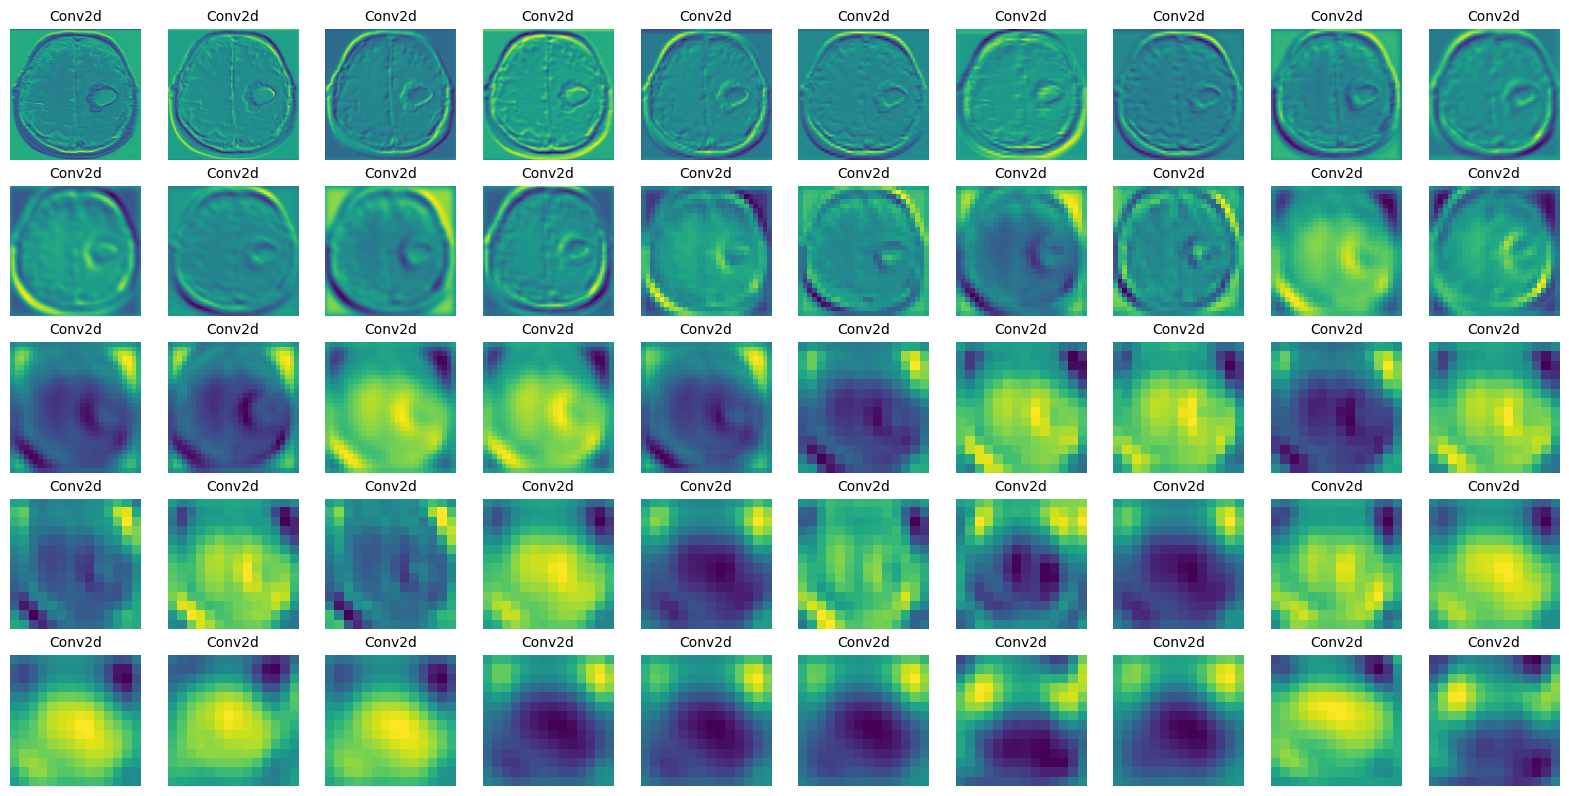

In [ ]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())

fig = plt.figure(figsize=(20, 20))
for i in range(50):
    a = fig.add_subplot(10, 10, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)

# Hyperparameter Tuning

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def cross_validate(dataset, num_epochs, batch_size, n_splits, loss_fn, learning_rate, device):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Define the lists to store the results of each fold
    # val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_specificities = []
    val_f1_scores = []
    val_roc_aucs = []
    val_pr_aucs = []

    pbar2 = tqdm(total=n_splits, desc='Cross Validation', position=1, leave=True)
    # Loop over each fold
    for fold, (train_ids, val_ids) in enumerate(kfold.split([X for X, _ in dataset], [y for _, y in dataset])):
        # print(f'FOLD {fold}')
        # print('--------------------------------')

        # Sample elements randomly from a given list of ids, no replacement.
        train_fold = torch.utils.data.Subset(dataset, train_ids)
        val_fold = torch.utils.data.Subset(dataset, val_ids)

        augmented_images = []
        for img_label in train_fold:
            augmented_images.extend(augmentation(img_label))

        transformed_val_dataset = []
        for img_label in val_fold:
            img, label = img_label
            transformed_img = validation_transform(img)
            transformed_val_dataset.append((transformed_img, label))


        trainloader = DataLoader(augmented_images, batch_size=batch_size, shuffle=True, num_workers=2)
        valloader = DataLoader(transformed_val_dataset, batch_size=batch_size, num_workers=2)
        model = EfficientNet()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        early_stopper = EarlyStopper(patience=5, min_delta=0.001)

        model.to(device)

        # Train the model for a specified number of epochs
        for epoch in range(1, num_epochs + 1):
            model.train()
            # print(f'Starting epoch {epoch}')
            current_loss = 0.0

            for inputs, targets in trainloader:
                inputs = inputs.to(device)
                targets = nn.functional.one_hot(targets, 2).float()
                targets = targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                loss.backward()
                optimizer.step()

                current_loss += loss.item()

            if early_stopper.early_stop(current_loss):
                print(f'Early stopping at epoch {epoch} with loss {current_loss:.4f}')
                break

        # Validation
        model.eval()
        val_targets = []
        val_outputs = []
        val_probabilities = []

        for inputs, targets in valloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            _, predicted_classes = torch.max(outputs, dim=1)
            predicted_probabilities = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
            val_targets.extend(targets.tolist())
            val_outputs.extend(predicted_classes.tolist())
            val_probabilities.extend(predicted_probabilities.tolist())

        # Calculate validation metrics
        # val_targets_one_hot = torch.nn.functional.one_hot(torch.tensor(val_targets), 2).float().to(device)
        # Make sure the val_outputs are either 0 or 1
        # val_outputs_binary = torch.max(torch.tensor(val_outputs).to(device), 1)[1].cpu()
        # val_loss = loss_fn(torch.tensor(val_outputs).to(device), val_targets_one_hot).cpu()
        precision, recall, _ = precision_recall_curve(val_targets, val_probabilities)
        pr_auc = auc(recall, precision)
        roc_auc = roc_auc_score(val_targets, val_probabilities)

        val_accuracy = accuracy_score(val_targets, val_outputs)
        val_precision = precision_score(val_targets, val_outputs)
        val_recall = recall_score(val_targets, val_outputs)
        val_f1 = f1_score(val_targets, val_outputs)
        tn, fp, fn, tp = confusion_matrix(val_targets, val_outputs).ravel()
        val_specificity = tn / (tn+fp)

        # val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_specificities.append(val_specificity)
        val_f1_scores.append(val_f1)
        val_roc_aucs.append(roc_auc)
        val_pr_aucs.append(pr_auc)
        pbar2.update(1)

    # Statistics
    # tqdm.write('Validation Summary')
    summary = dict()
    # summary['val_loss'] = np.mean(val_losses)
    summary['val_accuracy'] = np.mean(val_accuracies)
    summary['val_precision'] = np.mean(val_precisions)
    summary['val_recall'] = np.mean(val_recalls)
    summary['val_f1_score'] = np.mean(val_f1_scores)
    summary['val_specificity'] = np.mean(val_specificities)
    summary['val_roc_auc'] = np.mean(val_roc_aucs)
    summary['val_pr_auc'] = np.mean(val_pr_aucs)
    # tqdm.write(f'Val Loss: {summary["val_loss"]:.4f}')
    tqdm.write(f'Val Accuracy: {summary["val_accuracy"]:.4f}')
    tqdm.write(f'Val Precision: {summary["val_precision"]:.4f}')
    tqdm.write(f'Val Recall: {summary["val_recall"]:.4f}')
    tqdm.write(f'Val F1 Score: {summary["val_f1_score"]:.4f}')
    tqdm.write('--------------------------------')
    pbar2.close()
    return summary

In [ ]:
# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

def tune_hyperparameters():
    # Define the hyperparameters to try out
    num_epochs_list = [50]
    batch_size_list = [16, 32]
    learning_rate_list = [0.01, 0.001]
    weight_for_0 = (1 / class_counts[0]) * (sum(class_counts.values())) / 2.0
    weight_for_1 = (1 / class_counts[1]) * (sum(class_counts.values())) / 2.0
    weight = torch.tensor([weight_for_0, weight_for_1]).to(device)
    loss_fn_list = [nn.BCELoss(weight=weight), nn.BCELoss()]
    n_splits = 5

    combinations = len(num_epochs_list) * len(batch_size_list) * len(learning_rate_list) * len(loss_fn_list)

    # Define the results dictionary
    results = dict()
    best_acc = 0.0
    best_acc_params = ()
    best_recall = 0.0
    best_recall_params = ()
    best_specificity = 0.0
    best_specificity_params = ()
    best_roc_auc = 0.0
    best_roc_auc_params = ()
    best_pr_auc = 0.0
    best_pr_auc_params = ()

    pbar = tqdm(total=combinations, desc='Hyperparameter tuning', position=0)
    pbar.write(f"Total number of hyperparameter combinations to try: {combinations}")
    # Loop over hyperparameters
    for learning_rate in learning_rate_list:
        for loss_fn in loss_fn_list:
            for batch_size in batch_size_list:
                for num_epochs in num_epochs_list:
                    pbar.write(f'Testing hyperparams: num_epochs: {num_epochs}, batch_size: {batch_size}, learning_rate: {learning_rate}, loss_fn: {loss_fn}')
                    start_time = time.time()
                    summary = cross_validate(train_dataset, num_epochs, batch_size, n_splits, loss_fn, learning_rate, device)
                    results[(num_epochs, batch_size, learning_rate, loss_fn)] = summary

                    # Save the best model based on accuracy
                    if summary['val_accuracy'] > best_acc:
                        best_acc = summary['val_accuracy']
                        best_acc_params = (num_epochs, batch_size, learning_rate, loss_fn)

                    # Save the best model based on recall
                    if summary['val_recall'] > best_recall:
                        best_recall = summary['val_recall']
                        best_recall_params = (num_epochs, batch_size, learning_rate, loss_fn)

                    # Save the best model based on specificity
                    if summary['val_specificity'] > best_specificity:
                        best_specificity = summary['val_specificity']
                        best_specificity_params = (num_epochs, batch_size, learning_rate, loss_fn)

                    # Save the best model based on roc_auc
                    if summary['val_roc_auc'] > best_roc_auc:
                        best_roc_auc = summary['val_roc_auc']
                        best_roc_auc_params = (num_epochs, batch_size, learning_rate, loss_fn)

                    # Save the best model based on pr_auc
                    if summary['val_pr_auc'] > best_pr_auc:
                        best_pr_auc = summary['val_pr_auc']
                        best_pr_auc_params = (num_epochs, batch_size, learning_rate, loss_fn)

                    # pbar.write(f'Val Loss: {summary["val_loss"]:.4f}')
                    pbar.write(f'Val Precision: {summary["val_precision"]:.4f}')
                    pbar.write(f'Val Accuracy: {summary["val_accuracy"]:.4f}')
                    pbar.write(f'Val Recall: {summary["val_recall"]:.4f}')
                    pbar.write(f'Val F1 Score: {summary["val_f1_score"]:.4f}')
                    pbar.write(f'Val Specificity: {summary["val_specificity"]:.4f}')
                    pbar.write(f'Val ROC AUC: {summary["val_roc_auc"]:.4f}')
                    pbar.write(f'Val PR AUC: {summary["val_pr_auc"]:.4f}')
                    end_time = time.time()
                    pbar.write(f'Time taken: {end_time - start_time:.2f} seconds')
                    pbar.write('--------------------------------')
                    pbar.update(1)
    pbar.close()

    return results, best_acc, best_acc_params, best_recall, best_recall_params, best_specificity, best_specificity_params, # best_roc_auc, best_roc_auc_params, best_pr_auc, best_pr_auc_params


Using device:  cuda:0


In [ ]:
results, best_acc, best_acc_params, best_recall, best_recall_params, best_precision, best_precision_params, best_roc_auc, best_roc_auc_parms, best_pr_auc, best_pr_auc_params = tune_hyperparameters()
print(f'Best accuracy: {best_acc:.4f} with params: {best_acc_params}')
print(f'Best recall: {best_recall:.4f} with params: {best_recall_params}')
print(f'Best precision: {best_precision:.4f} with params: {best_precision_params}')
print(f'Best roc_auc: {best_roc_auc:.4f} with params: {best_roc_auc_parms}')
print(f'Best pr_auc: {best_pr_auc:.4f} with params: {best_pr_auc_params}')

Hyperparameter tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Total number of hyperparameter combinations to try: 8
Testing hyperparams: num_epochs: 50, batch_size: 16, learning_rate: 0.01, loss_fn: BCELoss()


Cross Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping at epoch 13 with loss 38.3593
Early stopping at epoch 17 with loss 33.0284
Early stopping at epoch 11 with loss 32.6000
Early stopping at epoch 15 with loss 34.2390
Early stopping at epoch 11 with loss 34.4967
Val Accuracy: 0.7393
Val Precision: 0.9148
Val Recall: 0.6616
Val F1 Score: 0.7610
--------------------------------
Val Precision: 0.9148
Val Accuracy: 0.7393
Val Recall: 0.6616
Val F1 Score: 0.7610
Val Specificity: 0.8802
Val ROC AUC: 0.8635
Val PR AUC: 0.9248
Time taken: 633.76 seconds
--------------------------------
Testing hyperparams: num_epochs: 50, batch_size: 32, learning_rate: 0.01, loss_fn: BCELoss()


Cross Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping at epoch 28 with loss 11.7028
Early stopping at epoch 24 with loss 11.8696
Early stopping at epoch 22 with loss 10.3663
Early stopping at epoch 16 with loss 12.9855
Early stopping at epoch 22 with loss 11.8106
Val Accuracy: 0.8261
Val Precision: 0.9132
Val Recall: 0.8149
Val F1 Score: 0.8561
--------------------------------
Val Precision: 0.9132
Val Accuracy: 0.8261
Val Recall: 0.8149
Val F1 Score: 0.8561
Val Specificity: 0.8495
Val ROC AUC: 0.9117
Val PR AUC: 0.9528
Time taken: 982.81 seconds
--------------------------------
Testing hyperparams: num_epochs: 50, batch_size: 16, learning_rate: 0.01, loss_fn: BCELoss()


Cross Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping at epoch 11 with loss 27.0279
Early stopping at epoch 14 with loss 25.9577
Early stopping at epoch 10 with loss 26.1757
Early stopping at epoch 15 with loss 29.0243
Early stopping at epoch 18 with loss 31.7036
Val Accuracy: 0.7881
Val Precision: 0.8801
Val Recall: 0.7801
Val F1 Score: 0.8232
--------------------------------
Val Precision: 0.8801
Val Accuracy: 0.7881
Val Recall: 0.7801
Val F1 Score: 0.8232
Val Specificity: 0.8022
Val ROC AUC: 0.8729
Val PR AUC: 0.9271
Time taken: 635.93 seconds
--------------------------------
Testing hyperparams: num_epochs: 50, batch_size: 32, learning_rate: 0.01, loss_fn: BCELoss()


Cross Validation:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# print(results)
columns = ["num_epochs", "batch_size", "learning_rate", "loss_fn", "val_accuracy", "val_precision", "val_recall", "val_specificity", "val_f1_score", "val_roc_auc", "val_pr_auc"]
rows = []
for keys, item in results.items():
    rows.append([keys[0], keys[1], keys[2], keys[3], item['val_accuracy'], item['val_precision'], item['val_recall'], item['val_specificity'], item['val_f1_score'], item['val_roc_auc'], item['val_pr_auc']])

df = pd.DataFrame(rows, columns=columns)

In [ ]:
df.sort_values(by=['val_pr_auc', 'val_roc_auc','val_recall', 'val_specificity', 'val_accuracy'], ascending=False, inplace=True)

In [ ]:
df

# Train with hyperparameter

In [ ]:

def train_test(train_set, test_set, num_epochs, batch_size, loss_fn, learning_rate, device):
    augmented_images = []
    for img_label in train_set:
        augmented_images.extend(augmentation(img_label))

    transformed_val_dataset = []
    for img_label in test_set:
        img, label = img_label
        transformed_img = validation_transform(img)
        transformed_val_dataset.append((transformed_img, label))

    trainloader = DataLoader(augmented_images, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(transformed_val_dataset, batch_size=batch_size, num_workers=2)
    model = EfficientNet()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    early_stopper = EarlyStopper(patience=5, min_delta=0.001)

    model.to(device)

    # Train the model for a specified number of epochs
    for epoch in tqdm(range(1, num_epochs + 1), desc='Training'):
        model.train()
        # print(f'Starting epoch {epoch}')
        current_loss = 0.0

        for inputs, targets in trainloader:
            inputs = inputs.to(device)
            targets = nn.functional.one_hot(targets, 2).float()
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            current_loss += loss.item()

        if early_stopper.early_stop(current_loss):
            print(f'Early stopping at epoch {epoch} with loss {current_loss:.4f}')
            break

    # Save weights
    counter = 1
    base_path = "model_weights"
    weights_path = os.path.join(base_path, f"model_weights_{counter}.pt")
    while os.path.exists(weights_path):
        counter += 1
        base_filename = f"model_weights_{counter}.pt"
        weights_path = os.path.join(base_path, base_filename)
    torch.save(model.state_dict(), weights_path)

    # Validation
    model.eval()
    val_targets = []
    val_outputs = []
    val_probabilities = []

    for i, data in enumerate(testloader, 0):
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)

        _, predicted_classes = torch.max(outputs, dim=1)
        predicted_probabilities = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
        val_targets.extend(targets.tolist())
        val_outputs.extend(predicted_classes.tolist())
        val_probabilities.extend(predicted_probabilities.tolist())

    # Calculate validation metrics
    # val_targets_one_hot = torch.nn.functional.one_hot(torch.tensor(val_targets), 2).float().to(device)
    # Make sure the val_outputs are either 0 or 1
    # val_outputs_binary = torch.max(torch.tensor(val_outputs).to(device), 1)[1].cpu()
    # val_loss = loss_fn(torch.tensor(val_outputs).to(device), val_targets_one_hot).cpu()
    precision, recall, _ = precision_recall_curve(val_targets, val_probabilities)
    pr_auc = auc(recall, precision)
    roc_auc = roc_auc_score(val_targets, val_probabilities)

    accuracy = accuracy_score(val_targets, val_outputs)
    precision = precision_score(val_targets, val_outputs)
    recall = recall_score(val_targets, val_outputs)
    f1 = f1_score(val_targets, val_outputs)
    tn, fp, fn, tp = confusion_matrix(val_targets, val_outputs).ravel()
    specificity = tn / (tn+fp)

    return model, accuracy, precision, recall, f1, specificity, roc_auc, pr_auc


# Results

In [ ]:
# Define the split ratio (e.g., 80% train, 20% test)
batch_size = 32
lr = 0.001
num_epochs = 30
weight_for_0 = (1 / class_counts[0]) * (sum(class_counts.values())) / 2.0
weight_for_1 = (1 / class_counts[1]) * (sum(class_counts.values())) / 2.0
weight = torch.tensor([weight_for_0, weight_for_1]).to(device)
loss_fn = nn.BCELoss(weight=weight)

model, accuracy, precision, recall, f1, specificity, roc_auc, pr_auc = train_test(train_dataset, test_dataset, num_epochs, batch_size, loss_fn, lr, device)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test Specificity: {specificity:.4f}')
print(f'Test F1 Score: {f1:.4f}')
print(f'Test ROC AUC: {roc_auc:.4f}')
print(f'Test PR AUC: {pr_auc:.4f}')